In [17]:
import os
import sys
import subprocess
import collections
import time
import nbformat
import socket
import re
import pickle
import nbformat

import numpy as np
import sklearn.metrics

import torch

lib_path = 'I:/code'
if not os.path.exists(lib_path):
  lib_path = '/media/6T/.tianle/.lib'
if not os.path.exists(lib_path):
  lib_path = '/projects/academic/azhang/tianlema/lib'
if os.path.exists(lib_path) and lib_path not in sys.path:
  sys.path.append(lib_path)
  
from dl.utils.visualization.visualization import *
from dl.utils.train import eval_classification, get_label_prob
from dl.utils.utils import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
def load_results(disease_type_str = '0', #0-1-6-8-10-11-16-17
                  model_name = 'ml',
                  sel_set_idx = 0,
                  data_type_str = 'gene-mirna-rppa-methy',
                  data_split_str = '70-10-20',
                  hidden_dim_str = '100-100',
                  filefolder = 'results',
                  target_variable = 'pfi',
                  return_variable='metric_all',
                  filename=None, plot_acc=True, plot_loss=True):
  if filename is None:
    filename = (f'{filefolder}/{disease_type_str}_{data_type_str}_set{sel_set_idx}' 
                f'_{data_split_str}_{target_variable}_{hidden_dim_str}_{model_name}.pkl')
    
  with open(filename, 'rb') as f:
    data = pickle.load(f)
  if return_variable in data:
    return np.array(data[return_variable])
  metric = np.array(data['metric_all'])
  confusion_mat = np.array(data['confusion_mat_all'])
  model_names, split_names, metric_names = (data['model_names'], data['split_names'], 
                                            data['metric_names'])
  # sanity check
  assert metric.shape == (len(model_names), len(split_names), len(metric_names))
  assert confusion_mat.shape[:2] == (len(model_names), len(split_names))
  loss_his = data['loss_his_all']
  acc_his = np.array(data['acc_his_all'])
  title =  disease_type_str if len(disease_type_str)>2 else disease_stats[int(disease_type_str)]
  if plot_acc and len(acc_his)>0:
    for i, n in enumerate(split_names):
      plot_history(acc_his[:, i].T, title=f'{title} {n} acc', 
                   indices=None, colors='rgbkmc', markers='ov+*,<',
                       labels=model_names, linestyles=['']*6, markersize=3)
    for i, n in enumerate(model_names):
      plot_history(acc_his[i].T, title=f'{title} {n} acc', 
                   indices=None, colors='rgbkmc', markers='ov+*,<',
                       labels=split_names, linestyles=['']*6, markersize=3)
  if plot_loss and len(loss_his)>0:
    for i, n in enumerate(model_names):
      history = np.array(loss_his[i])
      if history.ndim == 2:
        plot_history(history.T, title=f'{title} {n} loss', indices=None, colors='rgbkmc', 
                     markers='ov+*,<',
                       labels=split_names, linestyles=['']*6, markersize=3)
      elif history.ndim == 3:
        for j in range(history.shape[2]):
           plot_history(history[:,:,j].T, title=f'{title} {n} loss{j}', indices=None, 
                        colors='rgbkmc', markers='ov+*,<',
                       labels=split_names, linestyles=['']*6, markersize=3)
      else:
        raise ValueError(f'{filename} {n} loss has unexpected shape')
  if return_variable == 'all':
    return metric, confusion_mat, model_names, split_names, metric_names, acc_his, loss_his

def new_notebook(kwargs, filename='notebook.ipynb', notebook_folder='.', 
               template_file='template.ipynb', 
               slurm_script='../gpu-slurm', 
               new_file=False, submit=False, run_local=True,
               cell_idx=2, gpu_id=3):
  """Create notebook and run it on dlm or submit to ccr slurm
  """
  nb = nbformat.read(f'{template_file}', 4)
#   nb['cells'][0]['source'] = ("import socket\nif socket.gethostname() == 'dlm':\n"
#                               "  %env CUDA_DEVICE_ORDER=PCI_BUS_ID\n"
#                               f"  %env CUDA_VISIBLE_DEVICES={gpu_id}")
  new_source = ''
  for k, v in kwargs.items():
    if isinstance(v, str):
      new_source += f"{k} = '{v}'\n"
    elif isinstance(v, (list, tuple)):
      new_source += '{} = [{}]\n'.format(k, ', '.join(map(str, v)))
    else:
      new_source += f'{k} = {v}\n'
  new_source = new_source[:-1]   # remove the last '\n'     
  nb['cells'][cell_idx]['source'] = new_source
  if os.path.exists(f'{notebook_folder}/{filename}'):
    print(f'To overwrite file {notebook_folder}/{filename}')
  else:
    print(f'To create file {notebook_folder}/{filename}')
  if new_file:
    if not os.path.exists(notebook_folder):
      os.makedirs(notebook_folder)
    nbformat.write(nb, f'{notebook_folder}/{filename}')
  
  if submit: # sometimes I just want to create files
    if re.search('ccr.buffalo.edu$', socket.gethostname()) and not run_local:
      command = f'sbatch {slurm_script} {notebook_folder}/{filename} {filename}'
      subprocess.run(command, shell=True)
      print(command)
    else:
      command = ['jupyter nbconvert', '--ExecutePreprocessor.timeout=360000',
               '--ExecutePreprocessor.allow_errors=True', '--to notebook', '--execute']
      command.append(f'{notebook_folder}/{filename} --output {filename}')
      command = ' '.join(command)
      start_time = time.time()
      tmp = subprocess.run(command, shell=True)
      end_time = time.time()
      print(f'Time spent: {end_time-start_time:.2f}')
  return filename

In [19]:
for target_name in ['overall_survival', 'pfi', 'tumor_stage', 'sample_type']:
  seeds = range(30, 40)
  if target_name == 'sample_type':
    split_portion = [5, 5, 90]
    lr = 1e-3
  else:
    split_portion = [7, 1, 2]
    lr = 1e-2
  kwargs = {'target_name': target_name, 'seeds': seeds, 'split_portion': split_portion,
           'lr': lr}
  split_portion_str = np.array(split_portion)
  split_portion_str = split_portion_str * 100 / split_portion_str.sum()
  split_portion_str = '-'.join(map(lambda s: str(int(s)), split_portion_str))
  filename = f'workflow_{target_name}_{split_portion_str}.ipynb'

  new_notebook(kwargs, filename=filename, notebook_folder='.', 
                 template_file='workflow-v3.ipynb', 
                 slurm_script='gpu-slurm', 
                 new_file=True, submit=False, run_local=True,
                 cell_idx=3)

To overwrite file ./workflow_overall_survival_70-10-20.ipynb
To overwrite file ./workflow_pfi_70-10-20.ipynb
To overwrite file ./workflow_tumor_stage_70-10-20.ipynb
To overwrite file ./workflow_sample_type_5-5-90.ipynb


# These are for GeneNet

In [91]:
target_name = 'overall_survival'
target_name = 'pfi'
target_name = 'tumor_stage'
target_name = 'sample_type'
prefix = 'ccr/'
seeds = range(10)
seeds = range(10, 20)
seeds = range(20, 30)
# seeds = range(30, 40)
if target_name == 'sample_type':
  split_portion_str = '10-10-80'
  split_portion_str = '5-5-90'
else:
  split_portion_str = '60-20-20'
  split_portion_str = '70-10-20'

if target_name == 'sample_type':
  # num['01'] >= 100 and num['11'] >= 50
  cancer_type_done = ['LUAD', 'LIHC', 'BRCA', 'KIRC', 'PRAD', 'THCA']
elif target_name == 'tumor_stage':
  # min_num_per_cls = 100, min_num_per_type = 200
  cancer_type_done = ['LUSC', 'LUAD', 'BLCA', 'BRCA', 'KIRC', 'THCA']
elif target_name == 'pfi':
  # num[0] >= 100, num[1] >= 100
  cancer_type_done = ['BLCA', 'BRCA', 'COAD', 'HNSC', 'KIRC', 'LGG', 'LIHC', 'LUAD', 
                      'LUSC', 'OV', 'SARC', 'SKCM', 'STAD', 'UCEC']
elif target_name == 'overall_survival':
  # num[0] >= 100, num[1] >= 100
  cancer_type_done = ['BLCA', 'BRCA', 'COAD', 'HNSC', 'KIRC', 'LGG', 'LIHC', 'LUAD',
                      'LUSC', 'OV', 'SKCM', 'STAD']

for sel_proj_id in cancer_type_done: 
  for seed in seeds:
    filename = (f'{prefix}results/results/{sel_proj_id}_{split_portion_str}_seed{seed}'
                f'_{target_name}.pkl')
    if not os.path.exists(filename):
      print(filename)

set([s[:4] for s in os.listdir(f'{prefix}results/results/') if s.endswith(f'{target_name}.pkl')])

{'BRCA', 'KIRC', 'LIHC', 'LUAD', 'PRAD', 'THCA'}

In [135]:
# cancer_type_done = ['JIA', 'JIA-AC', 'JIA-CH']

In [136]:
results = {}
cancer_types = []
for cancer_type in cancer_type_done:
  metrics = []
  for seed in seeds:
    filename = (f'{prefix}results/results/{cancer_type}_{split_portion_str}_seed{seed}'
                f'_{target_name}.pkl')
    if os.path.exists(filename):
      metric = load_results(filename=filename, return_variable='metric_all')
      model_names_per_file = load_results(filename=filename, return_variable='model_names')
      metric_names = load_results(filename=filename, return_variable='metric_names')
      if metric.shape == (len(model_names_per_file), 3, 7):
        metrics.append(metric)
  metrics = np.array(metrics)
  if metrics.ndim == 4:
    print(cancer_type, metrics.shape)
    cancer_types.append(cancer_type)
    results[cancer_type] = metrics

In [93]:
# result comparison
metric_idx = 3
split_idx = 2
print(metric_names[metric_idx], ['Train', 'Val', 'Test'][split_idx], target_name)
for cancer_type in cancer_types:
  print()
  print(cancer_type)
  model_names_all = np.array(model_names_per_file)
  res_all = results[cancer_type]
  
  # i = 5
  # subset = range(6*i, 6*i+6)
  # subset = range(i, len(model_names_all), 6)
  subset = range(len(model_names_all))
  if res_all.ndim==4:
    mean = res_all.mean(axis=0)[subset]
    std = res_all.std(axis=0)[subset]
  else:
    mean = res_all[subset]
    std = np.zeros_like(mean)
  model_names = model_names_all[subset]
  sorted_idx = np.argsort(-mean, axis=0)
  mean = mean[sorted_idx[:, split_idx, metric_idx], split_idx, metric_idx]
  std = std[sorted_idx[:, split_idx, metric_idx], split_idx, metric_idx]
  names = model_names[sorted_idx[:, split_idx, metric_idx]]
  res = [(i+1, n, m, sd) for i, (n, m, sd) in enumerate(zip(names, mean, std))]
  print('{:^4} {:^50} {:^5} \t {:^5}'.format('Rank', 'Name', 'Mean', 'Std'))
  for s in res:
    print(f'{s[0]:^4} {s[1]:^50} {s[2]:^.3f} \t {s[3]:^.3f}')

f1_score Test sample_type

LUAD
Rank                        Name                        Mean  	  Std 
 1                          SVM                         0.992 	 0.004
 2                        RandMLP                       0.991 	 0.006
 3                    PrototypicalNet1                  0.990 	 0.008
 4                        RandGCN                       0.990 	 0.007
 5                   RandBipartiteGraph                 0.989 	 0.009
 6                          GCN                         0.983 	 0.012
 7                          MLP                         0.979 	 0.021
 8                     BipartiteGraph                   0.973 	 0.024
 9                      RandGeneNet                     0.963 	 0.018
 10                       GeneNet                       0.960 	 0.027
 11                     RandPathNet                     0.958 	 0.023
 12                       PathNet                       0.954 	 0.032
 13                    Random Forest                    0.

In [94]:
# result comparison
metric_idx = [1,2,3]
primary_metric_idx = 3
split_idx = 2
print(metric_names[metric_idx], ['Train', 'Val', 'Test'][split_idx])
for cancer_type in cancer_types:
  print()
  print(cancer_type)
  model_names_all = np.array(model_names_per_file)
  res_all = results[cancer_type]
#   model_names_all = np.concatenate([[m+str(i) for m in model_names_all] 
#                                     for i in range(res_all.shape[0])])
#   res_all = res_all.reshape(-1, 3, 7)

  # i = 5
  # subset = range(6*i, 6*i+6)
  # subset = range(i, len(model_names_all), 6)
  subset = range(len(model_names_all))
  if res_all.ndim==4:
    mean = res_all.mean(axis=0)[subset]
    std = res_all.std(axis=0)[subset]
  else:
    mean = res_all[subset]
    std = np.zeros_like(mean)
  model_names = model_names_all[subset]
  sorted_idx = np.argsort(-mean, axis=0)
  mean = mean[sorted_idx[:, split_idx, primary_metric_idx][:,None], split_idx, metric_idx]
  std = std[sorted_idx[:, split_idx, metric_idx], split_idx, metric_idx]
  names = model_names[sorted_idx[:, split_idx, primary_metric_idx]]
  res = [(i+1, n, m, sd) for i, (n, m, sd) in enumerate(zip(names, mean, std))]
  print('{:^4} {:^50} {} '.format('Rank', 'Name', 
                                  ' & '.join([metric_names[i] for i in metric_idx])))
  for s in res:
    print('{:^4} {:^50} {} '.format(
      s[0], s[1], ' & '.join(map(lambda s: f'{s:.3f}',s[2]))))

['precision' 'recall' 'f1_score'] Test

LUAD
Rank                        Name                        precision & recall & f1_score 
 1                          SVM                         0.992 & 0.992 & 0.992 
 2                        RandMLP                       0.991 & 0.991 & 0.991 
 3                    PrototypicalNet1                  0.991 & 0.990 & 0.990 
 4                        RandGCN                       0.990 & 0.990 & 0.990 
 5                   RandBipartiteGraph                 0.989 & 0.989 & 0.989 
 6                          GCN                         0.985 & 0.983 & 0.983 
 7                          MLP                         0.982 & 0.980 & 0.979 
 8                     BipartiteGraph                   0.977 & 0.976 & 0.973 
 9                      RandGeneNet                     0.968 & 0.966 & 0.963 
 10                       GeneNet                       0.967 & 0.965 & 0.960 
 11                     RandPathNet                     0.965 & 0.963 & 0.958 

In [ ]:
# result comparison
metric_idx = 5#[0, 3, 6, 5]
split_idx = 2
print(metric_names[metric_idx], ['Train', 'Val', 'Test'][split_idx])
for cancer_type in cancer_types:
  print()
  print(cancer_type)
  model_names_all = np.array(model_names_per_file)
  res_all = results[cancer_type]
  model_names_all = np.concatenate([[m+str(i) for m in model_names_all] 
                                    for i in range(res_all.shape[0])])
  res_all = res_all.reshape(-1, 3, 7)

  # i = 5
  # subset = range(6*i, 6*i+6)
  # subset = range(i, len(model_names_all), 6)
  subset = range(len(model_names_all))
  if res_all.ndim==4:
    mean = res_all.mean(axis=0)[subset]
    std = res_all.std(axis=0)[subset]
  else:
    mean = res_all[subset]
    std = np.zeros_like(mean)
  model_names = model_names_all[subset]
  sorted_idx = np.argsort(-mean, axis=0)
  mean = mean[sorted_idx[:, split_idx, metric_idx], split_idx, metric_idx]
  std = std[sorted_idx[:, split_idx, metric_idx], split_idx, metric_idx]
  names = model_names[sorted_idx[:, split_idx, metric_idx]]
  res = [(i+1, n, m, sd) for i, (n, m, sd) in enumerate(zip(names, mean, std))]
  print('{:^4} {:^50} {:^5} \t {:^5}'.format('Rank', 'Name', 'Mean', 'Std'))
  for s in res:
    print(f'{s[0]:^4} {s[1]:^50} {s[2]:^.3f} \t {s[3]:^.3f}')

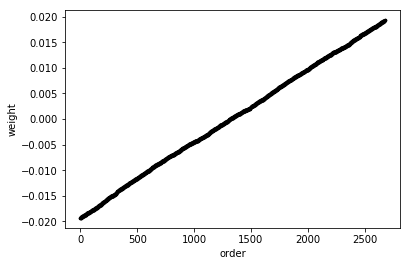

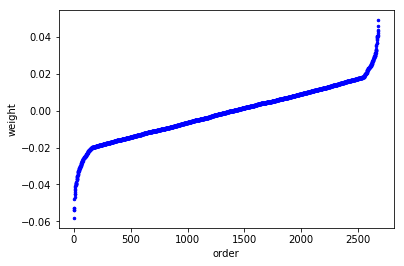

In [104]:
with open('ccr/results/results/KIRC_5-5-90_seed24_sample_type.pkl', 'rb') as f:
  data = pickle.load(f)
  name_to_id_go = data['name_to_id_go']
  go_weight_bipartite_graph = data['go_weight_bipartite_graph']

bound = np.sqrt(1/len(name_to_id_go))
random_weight = np.random.uniform(-bound, bound, (len(name_to_id_go),))
plt.plot(sorted(random_weight), 'k.', markersize=5)
plt.xlabel('order')
plt.ylabel('weight')
plt.savefig('figs/random_weight_KIRC.png', dpi=150, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)
plt.show()

plt.plot(sorted(go_weight_bipartite_graph[1]), 'b.', markersize=5)
plt.xlabel('order')
plt.ylabel('weight')
plt.savefig('figs/learned_weight_KIRC.png', dpi=150, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)
plt.show()

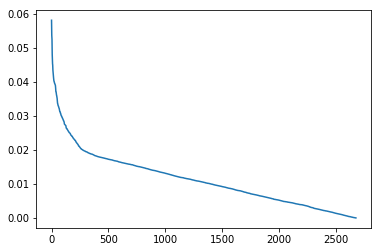

In [128]:
sorted_go_weight = np.abs(go_weight_bipartite_graph[1])[np.argsort(-np.abs(go_weight_bipartite_graph[1]))]
plt.plot(np.abs(go_weight_bipartite_graph[1])[np.argsort(-np.abs(go_weight_bipartite_graph[1]))])

In [114]:
np.argsort(-np.abs(go_weight_bipartite_graph[1]))[:10]

array([2544,   29,  408,  243, 1249, 2334,  658, 2127,  812,  834],
      dtype=int64)

In [116]:
id_to_name_go = {i: n for n, i in name_to_id_go.items()}

go_names = np.array([v for k, v in sorted(id_to_name_go.items())])

selected_go_ids = go_names[np.argsort(-np.abs(go_weight_bipartite_graph[1]))[:10]]

overwrite = False
filename = 'goa_human.gaf.gz'
# filename = 'goa_human.gpa.gz'
# filename = 'goa_human.gpi.gz'
save_folder = 'F:/KnowledgeBases/GO'
filepath = '{}/{}'.format(save_folder, filename)
if overwrite or not os.path.exists(filepath):
  url = 'ftp://ftp.ebi.ac.uk/pub/databases/GO/goa/HUMAN'
  urllib.request.urlretrieve(f'{url}/{filename}', filepath)
  print(f'Update {filepath} from {url}/{filename}')
goa_human = pandas.read_table(filepath, comment='!', header=None)
gaf_format = pandas.read_html('http://geneontology.org/page/go-annotation-file-gaf-format-21')
gaf_columns = gaf_format[0].values[:, 1]
if filename.endswith('gpa.gz'):
  goa_human.columns = gpa_columns
elif filename.endswith('gaf.gz'):
  goa_human.columns = gaf_columns
elif filename.endswith('gpi.gz'):
  goa_human.columns = gpi_columns
# remove records with Qualifier starting with 'NOT';
# for 'goa_human.gaf.gz', most of the qualifiers are NA, assume they are valid
goa_human = goa_human[[s!=s or not s.startswith('NOT') for s in goa_human['Qualifier']]]

go_id_to_name = {s[0]: s[1] for s in goa_human[['GO ID', 'DB Object Name']].values}

for i, g in enumerate(selected_go_ids):
  print(f'{g} & {go_id_to_name[g]} & {sorted_go_weight[i]:.3f} \\\\')

# These results are used for BIBM 2018 submission
I ran 1000 iterations for each experiments;

This is for PFI only. I forgot how I processed DFI, probably based on partial data.

In [ ]:
# This is used to delete unused files and clean up disk space
filenames = set()
for i in ['all']:
  for j in range(10):
    for model_name in ['resnet', 'ml', 'densenet', 'nn']:
      filename = f'results/{i}_gene-mirna-rppa-methy_set{j}_70-10-20_pfi_100-100_{model_name}.pkl'
      filenames.add(filename)
      if not os.path.exists(filename):
          print(filename)

for i in ['all']:
  for j in range(10):
    for data_type_str in ['gene', 'mirna', 'rppa', 'methy']:
      filename = f'results/{i}_{data_type_str}_set{j}_70-10-20_pfi_100-100_nn.pkl'
      filenames.add(filename)
      if not os.path.exists(filename):
          print(filename)

for i in ['all']:
  for j in range(10):
    for model_name in ['resnet', 'densenet', 'nn']:
      filename = f'results/{i}_gene-mirna-rppa-methy_set{j}_70-10-20_pfi_100-100-100_{model_name}.pkl'
      filenames.add(filename)
      if not os.path.exists(filename):
          print(filename)
print('Number of files with 1000 iterations (the rest 100 iterations):', len(filenames))

# I changed the number of layers and hidden units
hidden_dim_strs = ['100', '200', '100-100', '100-200', '200-100', '100-100-100', 
                   '50-100-200', '100-50-200', '200-100-50', '200-100-50-10']
for target_variable in ['PFI', 'DFI']:
  for hidden_dim_str in hidden_dim_strs:
    for seed in range(10):
      filename=(f'results/{target_variable}_instance-shuffle_gene-methy-mirna-rppa_all'
                f'_100-0_0.7-0.1-0.2_10sets_{seed}_{hidden_dim_str}_nn.pkl')
      filenames.add(filename)
      if not os.path.exists(filename):
        print(filename)
# I also experiment with resnet and densenet for 100-100-100
for target_variable in ['PFI', 'DFI']:
  for model_name in ['resnet', 'densenet']:
    for seed in range(10):
      filename=(f'results/{target_variable}_instance-shuffle_gene-methy-mirna-rppa_all'
                f'_100-0_0.7-0.1-0.2_10sets_{seed}_100-100-100_{model_name}.pkl')
      filenames.add(filename)
      if not os.path.exists(filename):
        print(filename)
        
model_types = ['ml', 'nn', 'densenet', 'resnet']
for target_variable in ['PFI', 'DFI']:
  for model_name in model_types:
    for seed in range(10):
      filename=(f'results/{target_variable}_instance-shuffle_gene-methy-mirna-rppa_all'
                f'_100-0_0.7-0.1-0.2_10sets_{seed}_100-100_{model_name}.pkl')
      filenames.add(filename)
      if not os.path.exists(filename):
        print(filename)
# I also did four experiments on 0.5-0.2-0.3 data split        
for target_variable in ['PFI', 'DFI']:
  for shuffle_type in ['instance-shuffle', 'group-shuffle']:
    filename=(f'results/{target_variable}_{shuffle_type}_gene-methy-mirna-rppa_all'
              f'_100-0_0.5-0.2-0.3_10sets_0_100-100_nn.pkl')
    filenames.add(filename)
    if not os.path.exists(filename):
      print(filename)
print('Total number of files:', len(filenames))

# # remove old files to save disk space
# [os.remove(f'results/{f}') for f in os.listdir('results') 
#  if f.endswith('pkl') and f'results/{f}' not in filenames]

In [ ]:
# major results: using all the four data types with hidden_dim = [100,100]
res_all = np.array([np.concatenate(
  [load_results(disease_type_str='all', sel_set_idx=i, model_name=model_name, 
                hidden_dim_str='100-100', return_variable='metric_all') 
   for model_name in ['ml', 'resnet', 'nn', 'densenet']], axis=0) for i in range(10)])
all_model_names = np.concatenate([[f'{n}-{model_name}' for n in load_results(
  disease_type_str='all', sel_set_idx=0, model_name=model_name, hidden_dim_str='100-100', 
  return_variable='model_names')] for model_name in ['ml', 'resnet', 'nn', 'densenet']])
# I also run each data type alone using nn with hidden_dim = [100,100]
res_all = np.concatenate([res_all, 
  np.array([np.concatenate([load_results(disease_type_str='all', sel_set_idx=sel_set_idx, 
    model_name='nn', data_type_str=data_type_str, hidden_dim_str = '100-100', 
                                         return_variable='metric_all') 
    for data_type_str in ['gene', 'mirna', 'rppa', 'methy']], axis=0)
            for sel_set_idx in range(10)])], axis=1)
all_model_names = np.concatenate([all_model_names, np.concatenate([[f'{n}-nn-{data_type_str}' for n in load_results(disease_type_str='all', sel_set_idx=0, 
    model_name='nn', data_type_str=data_type_str, hidden_dim_str = '100-100', 
                                         return_variable='model_names')] 
    for data_type_str in ['gene','mirna', 'rppa', 'methy']])])
# I also try hidden_dim=[100,100,100]
res_all = np.concatenate([res_all, np.array([np.concatenate(
  [load_results(disease_type_str='all', sel_set_idx=i, model_name=model_name, 
    hidden_dim_str = '100-100-100',return_variable='metric_all') 
   for model_name in ['resnet', 'nn', 'densenet']], axis=0) for i in range(10)])], axis=1)
all_model_names = np.concatenate([all_model_names, np.concatenate(
  [[f'{n}-{model_name}-h3' for n in load_results(disease_type_str='all', sel_set_idx=0, 
                                              model_name=model_name, 
    hidden_dim_str = '100-100-100',return_variable='model_names')] 
   for model_name in ['resnet', 'nn', 'densenet']], axis=0)])
# shorten model names
all_model_names = np.array([s.replace(' ', '') for s in all_model_names])
all_model_names = np.array([s.replace('MultiviewAE', 'MAE') for s in all_model_names])

In [ ]:
idx = 5
# i = 5
# subset = range(6*i, 6*i+6)
# subset = range(i, len(all_model_names), 6)
subset = range(len(all_model_names))
names = all_model_names[subset][res_all.mean(axis=0)[subset].argsort(axis=0)[:,2,idx]]
values = np.sort(res_all.mean(axis=0)[subset], axis=0)[:,2,idx]
[(i, n, v) for i, (n, v) in enumerate(zip(names, values))]

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
ax.plot(np.sort(res_all.mean(axis=0), axis=0)[:,2,idx], 'ro')
ax.set_xticks(np.arange(len(all_model_names)))
ax.set_xticklabels(all_model_names[res_all.mean(axis=0).argsort(axis=0)[:,2,idx]], rotation=90)
plt.show()

In [ ]:
disease_type_str = 'all'#'0-1-6-8-10-11-16-17'
model_name = 'resnet'
sel_set_idx = 1
data_type_str = 'gene-mirna-rppa-methy'
data_split_str = '70-10-20'
hidden_dim_str = '100-100'
filefolder = 'results'
target_variable = 'pfi'
plot_acc = True
plot_loss = True
filename = (f'{filefolder}/{disease_type_str}_{data_type_str}_set{sel_set_idx}' 
            f'_{data_split_str}_{target_variable}_{hidden_dim_str}_{model_name}.pkl')
  

with open(filename, 'rb') as f:
  data = pickle.load(f)

metric = np.array(data['metric_all'])
confusion_mat = np.array(data['confusion_mat_all'])
model_names, split_names, metric_names = (data['model_names'], data['split_names'], 
                                          data['metric_names'])
assert metric.shape == (len(model_names), len(split_names), len(metric_names))
assert confusion_mat.shape[:2] == (len(model_names), len(split_names))
loss_his = data['loss_his_all']
acc_his = np.array(data['acc_his_all'])
title =  disease_type_str if len(disease_type_str)>2 else disease_stats[int(disease_type_str)]
if len(acc_his)>0 and plot_acc:
  for i, n in enumerate(split_names):
    plot_history(acc_his[:, i].T, title=f'{title} {n} acc', 
                 indices=None, colors='rgbkmc', markers='ov+*,<',
                     labels=model_names, linestyles=['']*6, markersize=3)
  for i, n in enumerate(model_names):
    plot_history(acc_his[i].T, title=f'{title} {n} acc', 
                 indices=None, colors='rgbkmc', markers='ov+*,<',
                     labels=split_names, linestyles=['']*6, markersize=3)
if len(loss_his)>0 and plot_loss:
  for i, n in enumerate(model_names):
    history = np.array(loss_his[i])
    if history.ndim == 2:
      plot_history(history.T, title=f'{title} {n} loss', indices=None, colors='rgbkmc', 
                   markers='ov+*,<',
                     labels=split_names, linestyles=['']*6, markersize=3)
    elif history.ndim == 3:
      for j in range(history.shape[2]):
         plot_history(history[:,:,j].T, title=f'{title} {n} loss{j}', indices=None, 
                      colors='rgbkmc', markers='ov+*,<',
                     labels=split_names, linestyles=['']*6, markersize=3)
    else:
      raise ValueError(f'{filename} {n} loss has unexpected shape')

In [ ]:
print([model_names[i] for i in metric[:, 2,:].argmax(axis=0)])
plot_history(metric[:, 2, :].T, title=title, 
               indices=None, colors='rgbkmc', markers='ov+*,<',
                   labels=model_names, linestyles=['']*6, markersize=5)

# Extended experiments with Adversarial AE and Variational AE

In [ ]:
# 'BLCA', 'LUAD', 'LIHC', 'SARC', 'HNSC', 'KIRC', 'LGG', 'LUSC', 'STAD'
for cancer_type in ['BLCA', 'LUAD', 'LIHC', 'SARC', 'HNSC', 'KIRC', 'LGG', 'LUSC', 'STAD']: 
  for seed in range(10):
    filename = (f'results/results/PFI_instance-shuffle_gene-methy-mirna-rppa_{cancer_type}_100-0_0.7-0.1-0.2'
      f'_10sets_{seed}_100-100_nn.pkl')
    if not os.path.exists(filename):
      print(filename)

In [ ]:
results = {}
cancer_types = ['BLCA', 'LUAD', 'LIHC', 'SARC', 'HNSC', 'KIRC', 'LGG', 'LUSC', 'STAD']
for cancer_type in cancer_types:
  metrics = []
  for seed in range(10):
    filename = (f'results/results/PFI_instance-shuffle_gene-methy-mirna-rppa_{cancer_type}_100-0_0.7-0.1-0.2'
      f'_10sets_{seed}_100-100_nn.pkl')
    if os.path.exists(filename):
      metric = load_results(filename=filename, return_variable='metric_all')
      model_names_per_file = load_results(filename=filename, return_variable='model_names')
      metric_names = load_results(filename=filename, return_variable='metric_names')
      if metric.shape == (len(model_names_per_file), 3, 7):
        metrics.append(metric)
  metrics = np.array(metrics)
  if metrics.ndim == 4:
    print(cancer_type, metrics.shape)
    results[cancer_type] = metrics

In [ ]:
# result comparison
metric_idx = 5
split_idx = 2
print(metric_names[metric_idx], ['Train', 'Val', 'Test'][split_idx])
for cancer_type in cancer_types:
  print()
  print(cancer_type)
  model_names_all = np.array(model_names_per_file)
  res_all = results[cancer_type]
  
  # i = 5
  # subset = range(6*i, 6*i+6)
  # subset = range(i, len(model_names_all), 6)
  subset = range(len(model_names_all))
  if res_all.ndim==4:
    mean = res_all.mean(axis=0)[subset]
    std = res_all.std(axis=0)[subset]
  else:
    mean = res_all[subset]
    std = np.zeros_like(mean)
  model_names = model_names_all[subset]
  sorted_idx = np.argsort(-mean, axis=0)
  mean = mean[sorted_idx[:, split_idx, metric_idx], split_idx, metric_idx]
  std = std[sorted_idx[:, split_idx, metric_idx], split_idx, metric_idx]
  names = model_names[sorted_idx[:, split_idx, metric_idx]]
  res = [(i+1, n, m, sd) for i, (n, m, sd) in enumerate(zip(names, mean, std))]
  print('{:^4} {:^50} {:^5} \t {:^5}'.format('Rank', 'Name', 'Mean', 'Std'))
  for s in res:
    print(f'{s[0]:^4} {s[1]:^50} {s[2]:^.3f} \t {s[3]:^.3f}')

In [ ]:
# result comparison
metric_idx = 5#[0, 3, 6, 5]
split_idx = 2
print(metric_names[metric_idx], ['Train', 'Val', 'Test'][split_idx])
for cancer_type in cancer_types:
  print()
  print(cancer_type)
  model_names_all = np.array(model_names_per_file)
  res_all = results[cancer_type]
  model_names_all = np.concatenate([model_names_all]*res_all.shape[0])
  res_all = res_all.reshape(-1, 3, 7)

  # i = 5
  # subset = range(6*i, 6*i+6)
  # subset = range(i, len(model_names_all), 6)
  subset = range(len(model_names_all))
  if res_all.ndim==4:
    mean = res_all.mean(axis=0)[subset]
    std = res_all.std(axis=0)[subset]
  else:
    mean = res_all[subset]
    std = np.zeros_like(mean)
  model_names = model_names_all[subset]
  sorted_idx = np.argsort(-mean, axis=0)
  mean = mean[sorted_idx[:, split_idx, metric_idx], split_idx, metric_idx]
  std = std[sorted_idx[:, split_idx, metric_idx], split_idx, metric_idx]
  names = model_names[sorted_idx[:, split_idx, metric_idx]]
  res = [(i+1, n, m, sd) for i, (n, m, sd) in enumerate(zip(names, mean, std))]
  print('{:^4} {:^50} {:^5} \t {:^5}'.format('Rank', 'Name', 'Mean', 'Std'))
  for s in res:
    print(f'{s[0]:^4} {s[1]:^50} {s[2]:^.3f} \t {s[3]:^.3f}')

In [ ]:
# result comparison
metric_idx = [6, 5]
primary_metric_idx = 5
split_idx = 2
print(metric_names[metric_idx], ['Train', 'Val', 'Test'][split_idx])
for cancer_type in cancer_types:
  print()
  print(cancer_type)
  model_names_all = np.array(model_names_per_file)
  res_all = results[cancer_type]
  model_names_all = np.concatenate([model_names_all]*res_all.shape[0])
  res_all = res_all.reshape(-1, 3, 7)

  # i = 5
  # subset = range(6*i, 6*i+6)
  # subset = range(i, len(model_names_all), 6)
  subset = range(len(model_names_all))
  if res_all.ndim==4:
    mean = res_all.mean(axis=0)[subset]
    std = res_all.std(axis=0)[subset]
  else:
    mean = res_all[subset]
    std = np.zeros_like(mean)
  model_names = model_names_all[subset]
  sorted_idx = np.argsort(-mean, axis=0)
  mean = mean[sorted_idx[:, split_idx, primary_metric_idx][:,None], split_idx, metric_idx]
  print(mean.shape)
  std = std[sorted_idx[:, split_idx, metric_idx], split_idx, metric_idx]
  names = model_names[sorted_idx[:, split_idx, primary_metric_idx]]
  res = [(i+1, n, m, sd) for i, (n, m, sd) in enumerate(zip(names, mean, std))]
  print('{:^4} {:^50} {} '.format('Rank', 'Name', 
                                  ' & '.join([metric_names[i] for i in metric_idx])))
  for s in res:
    print('{:^4} {:^50} {} '.format(
      s[0], s[1], ' & '.join(map(lambda s: f'{s:.3f}', s[2]))))

# I updated my code and run all the experiments again but only for 100 iterations


In [ ]:
load_results(return_variable='metric_names', 
  filename=(f'results/PFI_instance-shuffle_gene-methy-mirna-rppa_all'
            f'_100-0_0.7-0.1-0.2_10sets_0_100-100_nn.pkl'))

In [ ]:
# study if model architectures (number of layers and hidden units) affect performances
target_variable = 'PFI' # 'DFI'
res_all = np.stack([np.concatenate([load_results(return_variable='metric_all', 
             filename=(f'results/{target_variable}_instance-shuffle_gene-methy-mirna-rppa_all'
               f'_100-0_0.7-0.1-0.2_10sets_{seed}_{hidden_dim_str}_nn.pkl')) 
 for hidden_dim_str in hidden_dim_strs], axis=0) 
           for seed in range(10)], axis=0)

model_names_all = np.concatenate([[f'{n}_{hidden_dim_str}' 
                                   for n in load_results(return_variable='model_names', 
  filename=(f'results/{target_variable}_instance-shuffle_gene-methy-mirna-rppa_all'
            f'_100-0_0.7-0.1-0.2_10sets_0_{hidden_dim_str}_nn.pkl'))] 
  for hidden_dim_str in hidden_dim_strs], axis=0)
model_names_all = np.array([s.replace(' ', '') for s in model_names_all])
model_names_all = np.array([s.replace('MultiviewAE', 'MAE') for s in model_names_all])

metric_idx = 3
split_idx = 2
# i = 5
# subset = range(6*i, 6*i+6)
# subset = range(i, len(model_names_all), 6)
subset = range(len(model_names_all))
if res_all.ndim==4:
  mean = res_all.mean(axis=0)[subset]
  std = res_all.std(axis=0)[subset]
else:
  mean = res_all[subset]
  std = np.zeros_like(mean)
model_names = model_names_all[subset]
sorted_idx = np.argsort(-mean, axis=0)
mean = mean[sorted_idx[:, split_idx, metric_idx], split_idx, metric_idx]
std = std[sorted_idx[:, split_idx, metric_idx], split_idx, metric_idx]
names = model_names[sorted_idx[:, split_idx, metric_idx]]
res = [(i+1, n, m, sd) for i, (n, m, sd) in enumerate(zip(names, mean, std))]
print('{:^4} {:^50} {:^5} \t {:^5}'.format('Rank', 'Name', 'Mean', 'Std'))
for s in res:
  print(f'{s[0]:^4} {s[1]:^50} {s[2]:^.3f} \t {s[3]:^.3f}')

In [ ]:
# study if densenet and resnet are better than mlp
target_variable = 'DFI'
model_types = ['ml', 'nn', 'densenet', 'resnet']
hidden_dim_str = '100-100'
# # Another set of of experiments
# model_types = ['nn', 'densenet', 'resnet']
# hidden_dim_str = '100-100-100'
res_all = np.stack([np.concatenate([load_results(return_variable='metric_all', 
             filename=(f'results/{target_variable}_instance-shuffle_gene-methy-mirna-rppa_all'
               f'_100-0_0.7-0.1-0.2_10sets_{seed}_{hidden_dim_str}_{model_name}.pkl')) 
 for model_name in model_types], axis=0) 
           for seed in range(10)], axis=0)

model_names_all = np.concatenate([[f'{n}_{model_name}' 
                                   for n in load_results(return_variable='model_names', 
  filename=(f'results/{target_variable}_instance-shuffle_gene-methy-mirna-rppa_all'
            f'_100-0_0.7-0.1-0.2_10sets_0_100-100_{model_name}.pkl'))] 
  for model_name in model_types], axis=0)
model_names_all = np.array([s.replace(' ', '') for s in model_names_all])
model_names_all = np.array([s.replace('MultiviewAE', 'MAE') for s in model_names_all])

idx = 5
# i = 0
# subset = range(6*i, 6*i+6)
# subset = range(i, len(model_names_all), 6)
subset = range(len(model_names_all))
names = model_names_all[subset][res_all.mean(axis=0)[subset].argsort(axis=0)[:,2,idx]]
values = np.sort(res_all.mean(axis=0)[subset], axis=0)[:,2,idx]
[(i, n, v) for i, (n, v) in enumerate(zip(names, values))]

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
ax.plot(np.sort(res_all.mean(axis=0), axis=0)[:,2,idx], 'ro')
ax.set_xticks(np.arange(len(model_names_all)))
ax.set_xticklabels(model_names_all[res_all.mean(axis=0).argsort(axis=0)[:,2,idx]], rotation=90)
plt.show()

In [ ]:
target_variable = 'PFI' # 'DFI'
model_name = 'densenet'
sel_set_idx = 1
hidden_dim_str = '100-100'
filefolder = 'results'
plot_acc = True
plot_loss = True
filename = (f'{filefolder}/{target_variable}_instance-shuffle_gene-methy-mirna-rppa_all'
            f'_100-0_0.7-0.1-0.2_10sets_{sel_set_idx}_{hidden_dim_str}_{model_name}.pkl')
  

with open(filename, 'rb') as f:
  data = pickle.load(f)

metric = np.array(data['metric_all'])
confusion_mat = np.array(data['confusion_mat_all'])
model_names, split_names, metric_names = (data['model_names'], data['split_names'], 
                                          data['metric_names'])
assert metric.shape == (len(model_names), len(split_names), len(metric_names))
assert confusion_mat.shape[:2] == (len(model_names), len(split_names))
loss_his = data['loss_his_all']
acc_his = np.array(data['acc_his_all'])
title =  disease_type_str if len(disease_type_str)>2 else disease_stats[int(disease_type_str)]
if len(acc_his)>0 and plot_acc:
  for i, n in enumerate(split_names):
    plot_history(acc_his[:, i].T, title=f'{title} {n} acc', 
                 indices=None, colors='rgbkmc', markers='ov+*,<',
                     labels=model_names, linestyles=['']*6, markersize=3)
  for i, n in enumerate(model_names):
    plot_history(acc_his[i].T, title=f'{title} {n} acc', 
                 indices=None, colors='rgbkmc', markers='ov+*,<',
                     labels=split_names, linestyles=['']*6, markersize=3)
if len(loss_his)>0 and plot_loss:
  for i, n in enumerate(model_names):
    history = np.array(loss_his[i])
    if history.ndim == 2:
      plot_history(history.T, title=f'{title} {n} loss', indices=None, colors='rgbkmc', 
                   markers='ov+*,<',
                     labels=split_names, linestyles=['']*6, markersize=3)
    elif history.ndim == 3:
      for j in range(history.shape[2]):
         plot_history(history[:,:,j].T, title=f'{title} {n} loss{j}', indices=None, 
                      colors='rgbkmc', markers='ov+*,<',
                     labels=split_names, linestyles=['']*6, markersize=3)
    else:
      raise ValueError(f'{filename} {n} loss has unexpected shape')

In [ ]:
print([model_names[i] for i in metric[:, 2,:].argmax(axis=0)])
plot_history(metric[:, 2, :].T, title=title, 
               indices=None, colors='rgbkmc', markers='ov+*,<',
                   labels=model_names, linestyles=['']*6, markersize=5)

In [ ]:
# experiment with 50-20-30 data split
# group shuffle seems not work well
target_variable = 'DFI' # 'PFI'
shuffle_type = 'instance-shuffle' # 'group-shuffle'
res_all = load_results(return_variable='metric_all', 
             filename=(f'results/{target_variable}_{shuffle_type}_gene-methy-mirna-rppa_all'
               f'_100-0_0.5-0.2-0.3_10sets_0_100-100_nn.pkl'))

model_names_all = load_results(return_variable='model_names', 
  filename=(f'results/{target_variable}_{shuffle_type}_gene-methy-mirna-rppa_all'
            f'_100-0_0.5-0.2-0.3_10sets_0_100-100_nn.pkl'))
model_names_all = np.array([s.replace(' ', '') for s in model_names_all])
model_names_all = np.array([s.replace('MultiviewAE', 'MAE') for s in model_names_all])

idx = 5
split_idx = 2
# i = 3
# subset = range(6*i, 6*i+6)
# subset = range(i, len(model_names_all), 6)
subset = range(len(model_names_all))
names = model_names_all[subset][res_all[subset].argsort(axis=0)[:,split_idx,idx]]
values = np.sort(res_all[subset], axis=0)[:,split_idx,idx]
[(i, n, v) for i, (n, v) in enumerate(zip(names, values))]

# Causal Graph Attention Model

In [ ]:
# study if model architectures (number of layers and hidden units) affect performances
target_variable = 'PFI' # 'DFI'
for cancer_type in ['BLCA', 'LUAD', 'LIHC', 'SARC', 'HNSC', 'KIRC', 'LGG', 'LUSC', 'STAD']:
  seed = 2
  filename=(f'dag-results/{target_variable}_instance-shuffle_gene_{cancer_type}'
                f'_100-0_0.7-0.1-0.2_10sets_{seed}_100-100_nn.pkl')
  if os.path.exists(filename):
    print()
    res_all = load_results(return_variable='metric_all', filename=filename)
    model_names_all = load_results(return_variable='model_names', filename=filename)
    if len(res_all) > len(model_names_all):
      model_names_all = np.array(['DAG', 'NN', 'AE'] + list(model_names_all))
    # print(model_names_all)
    metric_names = load_results(return_variable='metric_names', filename=filename)

    metric_idx = 3
    print(f'{cancer_type}: {metric_names[metric_idx]}')
    split_idx = 2
    # i = 5
    # subset = range(6*i, 6*i+6)
    # subset = range(i, len(model_names_all), 6)
    subset = range(len(model_names_all))
    if res_all.ndim==4:
      mean = res_all.mean(axis=0)[subset]
      std = res_all.std(axis=0)[subset]
    else:
      mean = res_all[subset]
      std = np.zeros_like(mean)
    model_names = model_names_all[subset]
    sorted_idx = np.argsort(-mean, axis=0)
    mean = mean[sorted_idx[:, split_idx, metric_idx], split_idx, metric_idx]
    std = std[sorted_idx[:, split_idx, metric_idx], split_idx, metric_idx]
    names = model_names[sorted_idx[:, split_idx, metric_idx]]
    res = [(i+1, n, m, sd) for i, (n, m, sd) in enumerate(zip(names, mean, std))]
    print('{:^4} {:^50} {:^5} \t {:^5}'.format('Rank', 'Name', 'Mean', 'Std'))
    for s in res:
      print(f'{s[0]:^4} {s[1]:^50} {s[2]:^.3f} \t {s[3]:^.3f}')
  else:
    print(f'{filename} does not exist!')